<a href="https://colab.research.google.com/github/EzraFell2/User-Journey-Analysis-using-GA4-and-BigQuery/blob/main/REAL_ESTATE_B%E1%BA%A4T_%C4%90%E1%BB%98NG_S%E1%BA%A2N.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ga4-468103-3f381e69d384.json to ga4-468103-3f381e69d384.json


In [ ]:
!pip install --upgrade google-analytics-data

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 kB 5.1 MB/s eta 0:00:00


In [ ]:
!pip install --quiet google-cloud-bigquery pandas

In [ ]:
from google.cloud import bigquery
from google.oauth2 import service_account

KEY_PATH = "/content/ga4-468103-3f381e69d384.json"
credentials = service_account.Credentials.from_service_account_file(KEY_PATH)
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

print("Đã kết nối thành công đến BigQuery Project:", credentials.project_id)


Đã kết nối thành công đến BigQuery Project: ga4-468103


In [ ]:
from google.cloud import bigquery
# Sử dụng credentials đã load từ file JSON
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

# **B/ REAL ESTATE - TÌM NHÀ**

**I. CHUẨN BỊ DỮ LIỆU - TRUY VẤN**

---



In [ ]:
query_real_estate_events = """
WITH events AS (
  SELECT
    user_pseudo_id,
    TIMESTAMP_MICROS(event_timestamp) AS event_datetime,           -- full datetime
    DATE(TIMESTAMP_MICROS(event_timestamp)) AS event_date,         -- chỉ lấy ngày
    event_timestamp, -- Add event_timestamp here
    event_name,
    (SELECT value.string_value FROM UNNEST(event_params) WHERE key='page_location') AS page_location,
    traffic_source.source AS source,
    traffic_source.medium AS medium
  FROM `ga4-468103.analytics_470202691.events_intraday_*`
  WHERE _TABLE_SUFFIX BETWEEN '20250901' AND '20250915'
),
ordered AS (
  SELECT
    *,
    LAG(page_location) OVER (PARTITION BY user_pseudo_id ORDER BY event_datetime) AS prev_page,
    LAG(event_name) OVER (PARTITION BY user_pseudo_id ORDER BY event_datetime) AS prev_event
  FROM events
)
SELECT
  user_pseudo_id,
  event_datetime,
  page_location,
  prev_page,
  prev_event,
  source, medium
FROM ordered
WHERE REGEXP_CONTAINS(LOWER(page_location), r'/bat-dong-san/')  -- điều chỉnh pattern
ORDER BY event_datetime DESC
"""

In [ ]:
df_real_estate_events = client.query(query_real_estate_events).to_dataframe()
print(df_real_estate_events.head())

          user_pseudo_id                   event_datetime  \
0  1566493762.1757954041 2025-09-15 16:34:35.105597+00:00   
1  1566493762.1757954041 2025-09-15 16:34:30.540448+00:00   
2  2115070343.1757954050 2025-09-15 16:34:23.371812+00:00   
3  2115070343.1757954050 2025-09-15 16:34:18.171537+00:00   
4  1566493762.1757954041 2025-09-15 16:34:06.747323+00:00   

                                       page_location  \
0  https://www.fidovn.com/bat-dong-san/phong-tro-...   
1  https://www.fidovn.com/bat-dong-san/phong-tro-...   
2  https://www.fidovn.com/bat-dong-san/phong-tro-...   
3  https://www.fidovn.com/bat-dong-san/phong-tro-...   
4  https://www.fidovn.com/bat-dong-san/phong-tro-...   

                                           prev_page prev_event source medium  
0  https://www.fidovn.com/bat-dong-san/phong-tro-...  page_view   None   None  
1  https://www.fidovn.com/bat-dong-san/phong-tro-...    gtm.dom   None   None  
2  https://www.fidovn.com/bat-dong-san/phong-tro-...  pa

In [ ]:
query_real_estate_source_medium = """
SELECT source, medium, COUNT(DISTINCT user_pseudo_id) AS users_to_real_estate
FROM (
  SELECT user_pseudo_id,
         (SELECT value.string_value FROM UNNEST(event_params) WHERE key='page_location') AS page_location,
         traffic_source.source AS source,
         traffic_source.medium AS medium
  FROM `ga4-468103.analytics_470202691.events_intraday_*`
  WHERE _TABLE_SUFFIX BETWEEN '20250901' AND '20250915'
)
WHERE REGEXP_CONTAINS(LOWER(page_location), r'/bat-dong-san/')
GROUP BY source, medium
ORDER BY users_to_real_estate DESC
LIMIT 20;
"""
df_real_estate_source_medium = client.query(query_real_estate_source_medium).to_dataframe()
print(df_real_estate_source_medium.head())

     source   medium  users_to_real_estate
0      None     None                   484
1    google      cpc                   131
2  (direct)   (none)                    45
3    google  organic                    23
4      zalo     zalo                     3


In [ ]:
query_real_estate_funnel = """
SELECT
  user_pseudo_id,
  ARRAY_AGG(
    (SELECT value.string_value
     FROM UNNEST(event_params)
     WHERE key = 'page_location')
    ORDER BY event_timestamp
  ) AS path
FROM `ga4-468103.analytics_470202691.events_intraday_*`
WHERE _TABLE_SUFFIX BETWEEN '20250901' AND '20250915'
  AND (
        REGEXP_CONTAINS(
          (SELECT value.string_value
           FROM UNNEST(event_params)
           WHERE key = 'page_location'),
          r'/bat-dong-san'
        )
        OR
        (SELECT value.string_value
         FROM UNNEST(event_params)
         WHERE key = 'page_location') = 'https://www.fidovn.com/'
      )
GROUP BY user_pseudo_id;
"""
df_real_estate_funnel = client.query(query_real_estate_funnel).to_dataframe()
print(df_real_estate_funnel.head())

          user_pseudo_id                                               path
0   716393685.1755857463  [https://www.fidovn.com/, https://www.fidovn.c...
1  2062706151.1756999928                          [https://www.fidovn.com/]
2  1282408843.1757004706  [https://www.fidovn.com/, https://www.fidovn.c...
3  1787210764.1756544049  [https://www.fidovn.com/, https://www.fidovn.c...
4  1395510421.1757842629  [https://www.fidovn.com/, https://www.fidovn.c...


II. LÀM SẠCH DỮ LIỆU URL (PAGE PATH)

---



In [ ]:
import pandas as pd
import re

# Loại bỏ query string (?...) và anchor (#...)
def clean_url(url):
    if url is None:
        return None
    return re.split(r'[\?#]', url)[0]

df_real_estate_events['clean_page'] = df_real_estate_events['page_location'].apply(clean_url)
df_real_estate_funnel['clean_path'] = df_real_estate_funnel['path'].apply(lambda arr: [clean_url(p) for p in arr])

In [ ]:
import re

def categorize_page(url):
    if url is None:
        return "Unknown"

    elif clean_url in ["https://www.fidovn.com", "https://fidovn.com"]:
        return "Homepage"

    elif re.fullmatch(r'https://www\.fidovn\.com/bat-dong-san/?', url):
        return "Real Estate List"

    elif re.match(r'https://www\.fidovn\.com/bat-dong-san/.+', url):
        return "Real Estate Detail"

    else:
        return "Other"

df_real_estate_events['page_category'] = df_real_estate_events['clean_page'].apply(categorize_page)

**III. TRỰC QUAN HÓA DỮ LIỆU**

---



**Nguồn Traffic dẫn đến Job Pages (Các trang tìm việc)**


**Funnel chart: Homepage → Job List → Job Detail**

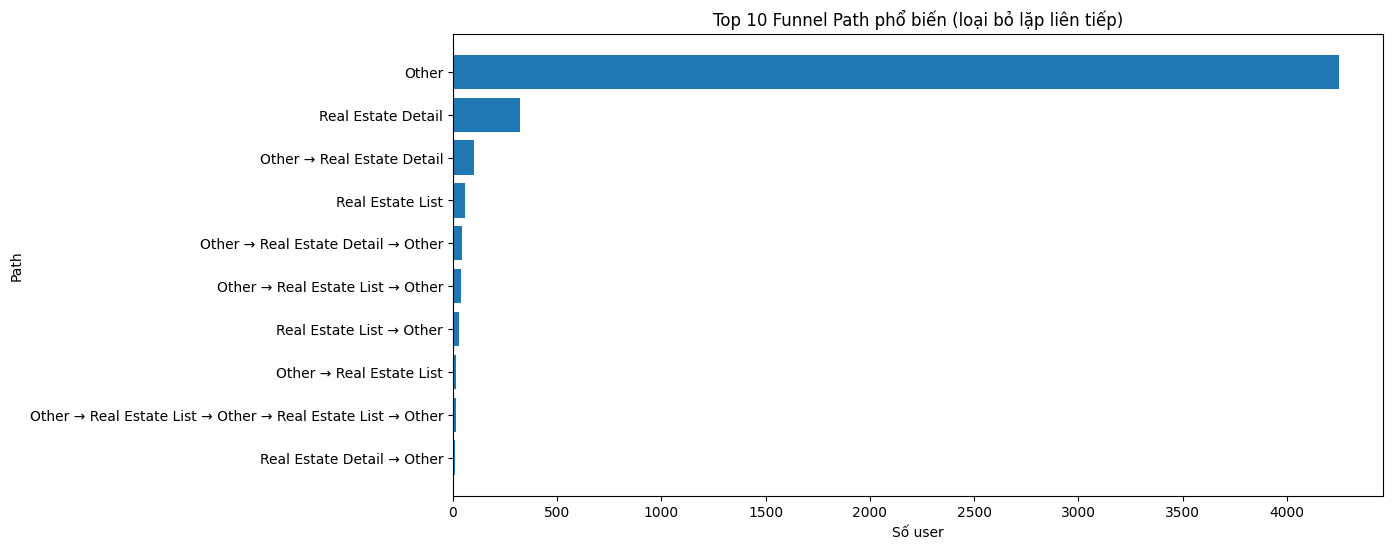

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt # Import matplotlib.pyplot

# Gom tất cả sequence
all_paths = []
for path in df_real_estate_funnel['clean_path']:
    cats = [categorize_page(p) for p in path]

    # Loại bỏ các bước lặp liên tiếp
    deduped = [cats[i] for i in range(len(cats)) if i == 0 or cats[i] != cats[i-1]]

    all_paths.append(" → ".join(deduped))

# Đếm tần suất các sequence
counter = Counter(all_paths)
df_house_funnel = pd.DataFrame(counter.items(), columns=["Path", "Count"]).sort_values("Count", ascending=False).head(10)

# Vẽ bar chart
plt.figure(figsize=(12,6))
plt.barh(df_house_funnel["Path"], df_house_funnel["Count"])
plt.title("Top 10 Funnel Path phổ biến (loại bỏ lặp liên tiếp)")
plt.xlabel("Số user")
plt.ylabel("Path")
plt.gca().invert_yaxis()
plt.show()

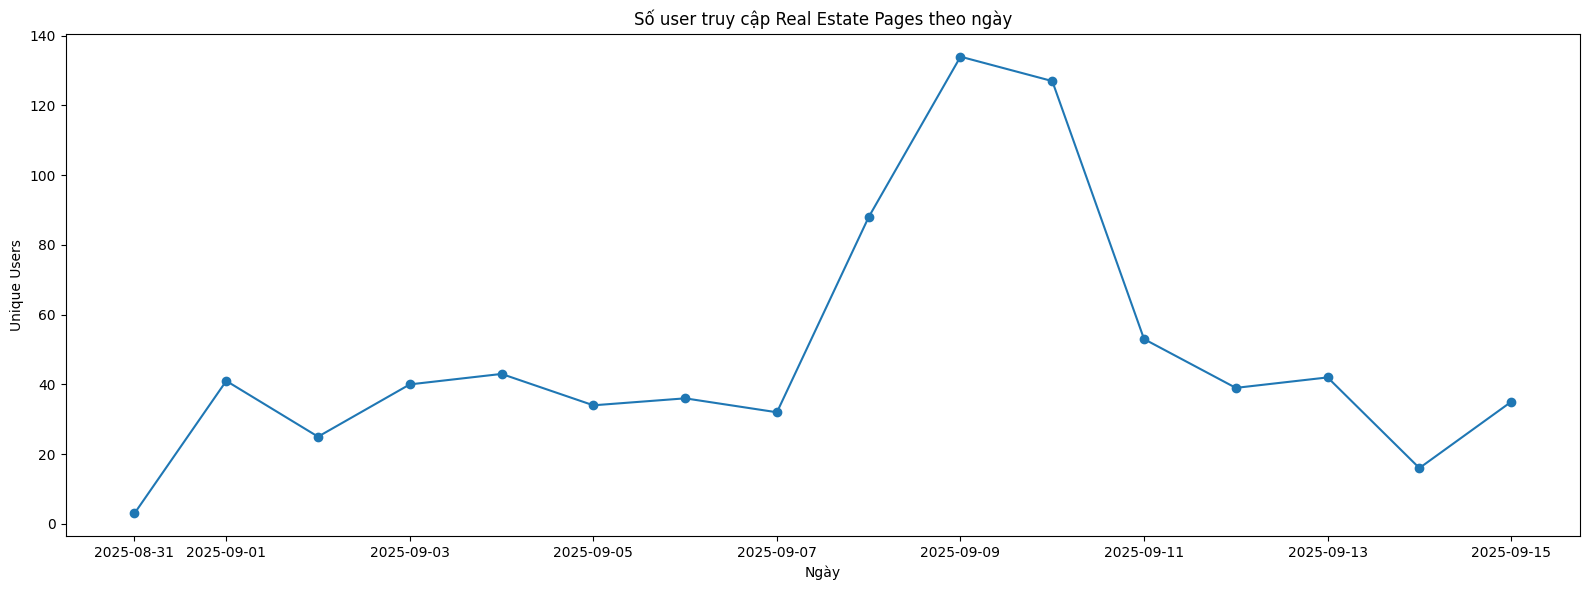

In [ ]:
df_real_estate_events['event_date'] = pd.to_datetime(df_real_estate_events['event_datetime']).dt.date
df_daily = df_real_estate_events.groupby('event_date')['user_pseudo_id'].nunique().reset_index()

plt.figure(figsize=(16,6))
plt.plot(df_daily['event_date'], df_daily['user_pseudo_id'], marker='o')
plt.title("Số user truy cập Real Estate Pages theo ngày")
plt.xlabel("Ngày")
plt.ylabel("Unique Users")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

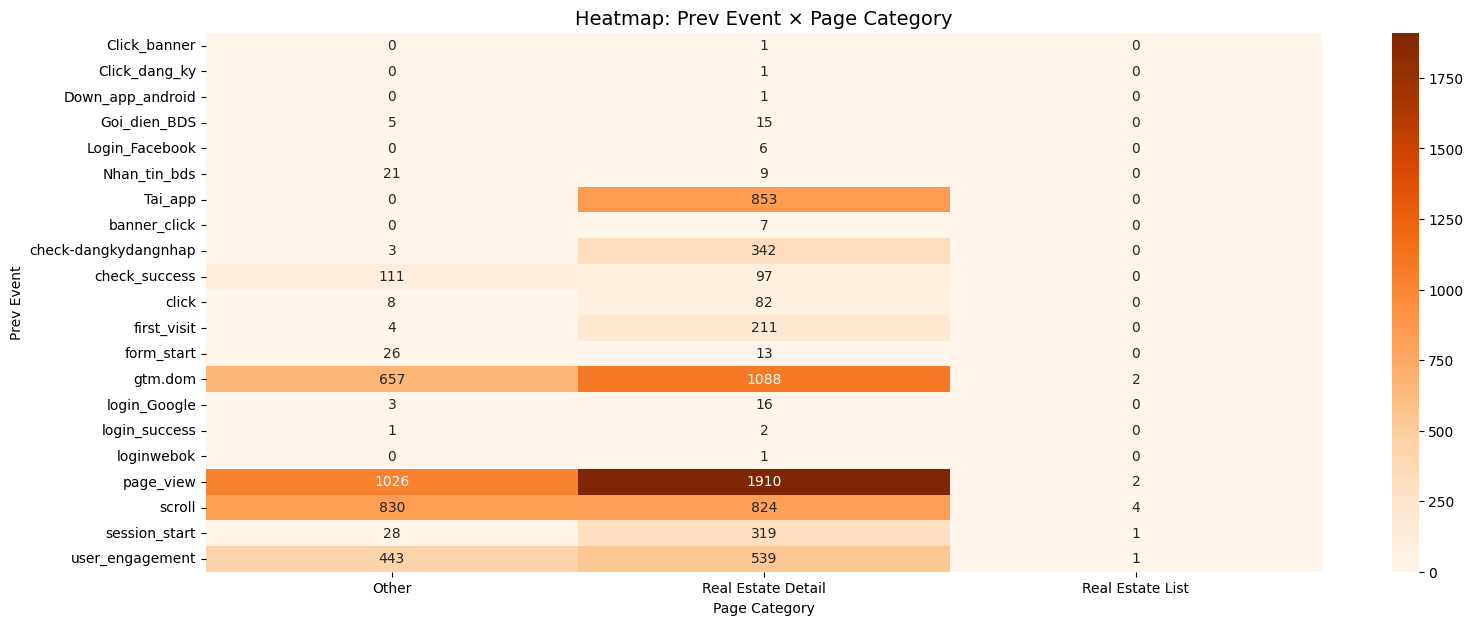

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Gom nhóm dữ liệu theo prev_event và page_category
df_prev = df_real_estate_events.groupby(
    ['prev_event','page_category']
).size().reset_index(name='count')

# Pivot để vẽ heatmap
pivot_prev = df_prev.pivot_table(
    index='prev_event',
    columns='page_category',
    values='count',
    fill_value=0
)

plt.figure(figsize=(18,7))
sns.heatmap(pivot_prev, annot=True, fmt=".0f", cmap="Oranges")
plt.title("Heatmap: Prev Event × Page Category", fontsize=14)
plt.xlabel("Page Category")
plt.ylabel("Prev Event")
plt.show()